In [19]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv("data.csv", index_col='Unnamed: 0')
df.head()

,9,17,18,23,46,86,99,104,128,158,...,135244,135273,135280,135281,135286,135313,135335,135339,135341,135353
466,3,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1721,10,8,0,5,0,0,8,0,0,0,...,0,6,0,6,6,0,7,0,5,5
2393,8,0,0,0,0,0,8,0,0,0,...,0,3,0,4,0,0,0,0,0,2
2852,9,0,0,0,0,0,0,0,0,0,...,0,4,0,5,0,0,0,0,0,2
3248,5,10,0,0,0,0,0,0,0,6,...,0,2,0,0,0,1,0,0,0,2


In [21]:
def get_mae(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    # Ignore zero terms.
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    mae = sum(abs(pred - actual)) / len(pred)
    return round(mae, 4)

In [27]:
def get_rmse(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    # Ignore zero terms.
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    rmse = (sum((pred - actual)**2) / len(pred))**0.5
    return round(rmse, 4)

# Baseline

In [28]:
def baseline_mae(df):    
    # build baseline prediction
    # female ~ row
    row_sum = df.sum(axis=1)
    row_non0 = (df != 0).astype(int).sum(axis=1)#(df!=0) return bool, astype change to int 1 / 0
    user_bias = np.around(row_sum / row_non0, decimals=4)# mean
    prediction_baseline = np.ones(df.shape[1]) * user_bias.values[:, np.newaxis]#df.shape[1] colume
    pred = pd.DataFrame(prediction_baseline, index=df.index, columns=df.columns)
    
    # MAE
    mae = get_mae(pred, df)
    rmse = get_rmse(pred, df)
    return 'MAE: ' + str(mae) + ' RMSE: ' + str(rmse)
#possible to change to another baseline?


In [29]:
baseline_mae(df)

'MAE: 1.1899 RMSE: 1.8014'

In [12]:
def baseline_rmse(df):    
    # build baseline prediction
    # female ~ row
    row_sum = df.sum(axis=1)
    row_non0 = (df != 0).astype(int).sum(axis=1)#(df!=0) return bool, astype change to int 1 / 0
    user_bias = np.around(row_sum / row_non0, decimals=4)# mean
    prediction_baseline = np.ones(df.shape[1]) * user_bias.values[:, np.newaxis]#df.shape[1] colume
    pred = pd.DataFrame(prediction_baseline, index=df.index, columns=df.columns)
    
    # MAE
    return get_rmse(pred, df)
#possible to change to another baseline?

# Split and Cross Vaildation

In [13]:
def split_dataset(df, per):
    import random as rd
    train = df.copy()
    for row in df.index:
        col_index = (df.columns.values).tolist() # 1000 male
        rd.shuffle(col_index)
        hidden_index = col_index[0: int(len(col_index)*per)]
        for col in hidden_index:
            train.loc[row, str(col)] = 0
    test = df - train
    return train, test 

In [7]:
train, test = split_dataset(df, 0.2)

In [14]:
import time
# rmse not added
def cross_vaildation(df, algo, param):
    tStart = time.time()
    train, test = split_dataset(df, 0.2) # 80% train, 20% test
    pred = algo(train, param) # run model
    
    mae = get_mae(pred, test)
    #rmse = get_rmse(pred, test)
    print(time.time()-tStart)
    return pred, test, mae

# Memory Base

In [15]:
from scipy.stats import pearsonr
def dot(K, L):
    return 0 if len(K) != len(L) else sum(i[0] * i[1] for i in zip(K, L))

def memory_based_CF(df, n):
    similarity = pd.DataFrame(index=df.index,columns=df.index)
    for i in similarity.columns :
        for j in similarity.columns :
            similarity.loc[i,j] = pearsonr(df.loc[i,:],df.loc[j,:])[0]
    df_neighbours = pd.DataFrame(index=similarity.columns,columns=range(1,n+1))
    for i in similarity.columns:
        df_neighbours.loc[i,:n] = similarity.loc[0:,i].sort_values(ascending=False)[1:n+1].index
    predicted_rating = []
    for k in range(len(df_neighbours.index)):
        #print (k)
        name = df_neighbours.index[k]
        neighbor = df_neighbours.loc[name].values.tolist()
        neighbor = df.loc[neighbor]
        nm = df.loc[name].to_frame()
        mean = nm.loc[nm[name] != 0].mean().values[0]
        score = []
        for i in neighbor.columns:
            rate_difference = []
            similarity_score = []
            rated = neighbor[i].loc[neighbor[i] != 0]
            if len(rated.index)==0:
                score.append(mean)
            else:
                rated_mean = rated.mean()
                if df.loc[name,i] == 0:
                    for j in rated.index:
                            rate_difference.append(rated.loc[j]-rated_mean)
                            similarity_score.append(similarity.loc[neighbor.index].loc[j,name])
                    score.append(mean + dot(rate_difference,similarity_score)/sum([abs(x) for x in similarity_score]))
                else:
                    score.append(df.loc[name,i])
        predicted_rating.append(score)
    return pd.DataFrame(data=predicted_rating, index=df.index, columns=df.columns)

In [10]:
mem_pred, mem_test, mem_mae = cross_vaildation(df, memory_based_CF, 10)
mem_mae

931.799628019


1.2081

In [11]:
mem_pred.head()

,9,17,18,23,46,86,99,104,128,158,...,135244,135273,135280,135281,135286,135313,135335,135339,135341,135353
466,3.00000,5.864636,5.864636,5.781559,5.864636,5.864636,7.000000,5.864636,5.864636,5.864636,...,5.864636,5.486998,5.864636,5.864636,5.928121,5.864636,5.864636,5.864636,5.864636,5.864636
1721,10.00000,8.000000,6.476873,6.480508,6.480508,6.480508,8.000000,6.480508,6.480508,6.480508,...,6.480508,6.000000,6.374468,6.000000,6.480508,6.156582,7.000000,6.480508,6.480508,6.157380
2393,8.00000,4.238208,4.259109,4.259109,4.266582,4.259109,8.000000,4.259109,4.259109,4.259109,...,4.259109,3.000000,4.219194,4.000000,4.259109,4.216089,4.275722,4.259109,4.259109,2.000000
2852,3.90455,3.810083,3.850328,3.789474,3.848867,3.789474,3.789474,3.789474,3.789474,3.789474,...,3.789474,4.000000,3.878563,5.000000,3.789474,3.789474,3.849226,3.789474,3.789474,3.742391
3248,4.68630,10.000000,4.632612,4.655550,4.655550,4.655550,4.655550,4.655550,4.655550,4.655550,...,4.655550,2.000000,4.634572,4.574347,4.303821,4.655550,4.391753,4.655550,4.655550,2.000000


In [12]:
mem_pred_1, mem_test_1, mem_mae_1 = cross_vaildation(df, memory_based_CF, 1)
mem_mae_1

479.18730998


1.1869

In [13]:
mem_pred_2, mem_test_2, mem_mae_2 = cross_vaildation(df, memory_based_CF, 2)
mem_mae_2

516.580508947


1.1986

In [14]:
mem_pred_3, mem_test_3, mem_mae_3 = cross_vaildation(df, memory_based_CF, 3)
mem_mae_3

581.817124844


1.1997

In [18]:
mem_pred_4, mem_test_4, mem_mae_4 = cross_vaildation(df, memory_based_CF, 4)
mem_mae_4

655.343516111


1.2029

In [19]:
mem_pred_5, mem_test_5, mem_mae_5 = cross_vaildation(df, memory_based_CF, 5)
mem_mae_5

1611.96712804


1.2029

In [20]:
mem_pred_6, mem_test_6, mem_mae_6 = cross_vaildation(df, memory_based_CF, 6)
mem_mae_6

779.941295147


1.2009

In [22]:
mem_pred_7, mem_test_7, mem_mae_7 = cross_vaildation(df, memory_based_CF, 7)
mem_mae_7

11525.7823319


1.2194

In [23]:
mem_pred_8, mem_test_8, mem_mae_8 = cross_vaildation(df, memory_based_CF, 8)
mem_mae_8

886.082050085


1.2083

In [24]:
mem_pred_9, mem_test_9, mem_mae_9 = cross_vaildation(df, memory_based_CF, 9)
mem_mae_9

933.279371977


1.2112

In [33]:
mem_result=[1.1869,1.1986,1.1997,1.2029,1.2029,1.2009,1.2194,1.2083,1.2112,1.2081]

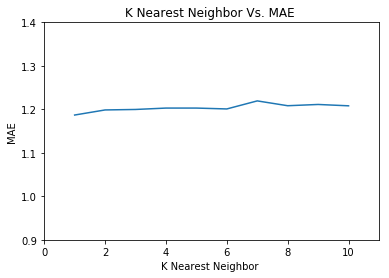

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('K Nearest Neighbor ')
plt.ylabel('MAE')
plt.title('K Nearest Neighbor Vs. MAE ')
plt.plot([1,2,3,4,5,6,7,8,9,10], mem_result)
plt.axis([0, 11, 0.9, 1.4])
plt.show()